In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # Barnes-Hut t-Distributed Stochastic Neighbour Embedding (t-SNE)

 Reference: [L. van der Maaten, "Accelerating t-SNE using Tree-Based Algorithms," J. Mach. Learn. Res., (2014)](https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf).

 ## t-SNE

 t-SNE is an algorithm that maps data points in a high-dimensional space
 ($\mathcal{D} = \{\boldsymbol{x}_1, \ldots, \boldsymbol{x}_n \}, \: \boldsymbol{x}_i \in \mathbb{R}^N$)
 to a 2-/3-dimensional embedding space ($\mathcal{E} = \{\boldsymbol{y}_1, \ldots, \boldsymbol{y}_n \}, \: \boldsymbol{y}_i \in \mathbb{R}^S$)
 while preserving as much as possible their local structure.

 The affinity in the original high-D space, $p_{j|i}$, is represented by Gaussian joint probabilities:

 $\begin{align} p_{j|i} &= \frac{ \mathcal{N}(d(\boldsymbol{x}_i, \boldsymbol{x}_j); 0, \sigma_i^2)}{\sum\limits_{k \neq i} \mathcal{N}(d(\boldsymbol{x}_i, \boldsymbol{x}_k); 0, \sigma_i^2)} \: (1 - \delta_{ij}) \\ p_{ij} &= \frac{p_{i|j} + p_{j|i}}{2 n} \\ \mathcal{N}(z; 0, \sigma^2) &= \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{z^2}{2 \sigma^2} \right) \end{align}$

 where $\sigma_i^2$ is width of the Gaussian kernel such that
 the *perplexity* at $\boldsymbol{x}_i$, $2^{H(P_i)}$,
 is equal to some given value $u$,
 where $H(P_i) = -\sum\limits_j p_{j|i} \log_2 p_{j|i}$ is the Shannon entropy.

 The affinity in the embedding space, $q_{j|i}$, is taken to follow the normalized Student-t distribution (with degree of freedom $n = 1$):

 $\begin{align} q_{ij} &= \frac{ \mathcal{T}(d(\boldsymbol{x}_i, \boldsymbol{x}_j); \nu = 1) }{\sum\limits_{k \neq l} \mathcal{T}(d(\boldsymbol{x}_k, \boldsymbol{x}_l); \nu = 1)} \: (1 - \delta_{ij}) \\ \mathcal{T}(z; \nu = 1) &= \frac{1}{\pi} \left(1 + z^2 \right)^{-1} \end{align}$

 The metric or distance function $d(\boldsymbol{x}_i, \boldsymbol{x}_j)$ could be the $L^2$ (Euclidean) norm $|| \boldsymbol{x}_i - \boldsymbol{x}_j ||_2$.

 The cost function $\mathcal{C}(\mathcal{E})$ is the Kullback-Leibler divergence between the two distributions:

 $\begin{align}  \mathcal{C}(\mathcal{E}) = D_\textrm{KL}(P \; || \; Q) = \sum\limits_{i, j \neq i} p_{ij} \: \log_2 \left( \frac{p_{ij}}{q_{ij}} \right) \end{align} $

 Although this function is non-convex, it can be minimized as usual by the gradient descent algorithm:

 $\begin{align} \frac{\partial \mathcal{C}}{\partial \boldsymbol{y}_i} &= 4 \sum\limits_{i, j \neq i} \left( p_{ij} - q_{ij} \right) q_{ij} \; A \left(\boldsymbol{y}_i - \boldsymbol{y}_j \right) \\ \boldsymbol{y}_i^{(m + 1)} &= \boldsymbol{y}_i^{(m)} - \eta \frac{\partial \mathcal{C}}{\partial \boldsymbol{y}_i} \end{align}$

 where $A = \sum\limits_{k \neq l} \mathcal{T}(d(\boldsymbol{x}_k, \boldsymbol{x}_l); \nu = 1)$ is a normalization term.

 The input affinities $p_{ij}$ can be approximated by noting its sparsity and restricting the denominator summation to $\mathcal{N}_i$,
 the set of $\lfloor 3 u \rfloor$ nearest neighbours to $\boldsymbol{x}_i$.

 $p_{ij} = \begin{cases} \frac{ \mathcal{N}(d(\boldsymbol{x}_i, \boldsymbol{x}_j); 0, \sigma_i^2)}{\sum\limits_{k \in \mathcal{N}_i} \mathcal{N}(d(\boldsymbol{x}_i, \boldsymbol{x}_k); 0, \sigma_i^2)} & \textrm{if } j \in \mathcal{N}_i \\ 0 & \textrm{otherwise} \end{cases}$

 $\mathcal{N}_i$ can be found by:

 1. building a *vantage-point tree* from $\mathcal{D}$ and $d(\boldsymbol{x}_i, \boldsymbol{x}_j)$;
 2. performing a nearest-neighbour search.



 ## Barnes-Hut Algorithm

 Note that the gradient of the cost function can be interpreted as the total force in a classical $n$-body problem:

 $\begin{align} \frac{\partial \mathcal{C}}{\partial \boldsymbol{y}_i} &= \left( 4 \sum\limits_{i, j \neq i} p_{ij} q_{ij} \; A \left(\boldsymbol{y}_i - \boldsymbol{y}_j \right) \right) + \left( - 4 \sum\limits_{i, j \neq i} q_{ij}^2 \; A \left(\boldsymbol{y}_i - \boldsymbol{y}_j \right) \right) \\ &= F_\textrm{att} + F_\textrm{rep} \end{align}$

 where $F_\textrm{att}, F_\textrm{rep}$ are spring-like attractive and repulsive forces.

 The term $q_{ij} \; A = \left(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_j||^2 \right)^{-1}$ can be computed $\mathcal{O}(1)$.

 The term $F_\textrm{att}$ can be computed efficiently by considering summing over only the non-zero elements
 of the sparse distribution $P$ that was constructed using $\mathcal{N}_i$.

 Minimization of this quantity can be achieved using the Barnes-Hut algorithm:

 1. construct an *octree* from the embedding $\mathcal{E} = \{ \boldsymbol{y}_1, \ldots, \boldsymbol{y}_n \}$;
 2. traverse the octree using a depth-first search;
 3. at each node, decide if the corresponding cell could be taken altogether as the contribution of all its children to $F_\textrm{att}, F_\textrm{rep}$;
    - $\frac{r_\textrm{cell}}{|| \boldsymbol{y}_i - \boldsymbol{y}_\textrm{cell} ||} < \theta$ for some given $\theta \sim 0.5$;
    - if true, $F_\textrm{rep} \; A \approx - 4 N_\textrm{cell} \; q_{i, \textrm{cell}}^2 \; A^2 (\boldsymbol{y}_i - \boldsymbol{y}_\textrm{cell})$;
    - $r_\textrm{cell}$, side length of the cell; $N_\textrm{cell}$, the number of points $\boldsymbol{y}_i$ in the cell;
    - $\boldsymbol{y}_\textrm{cell}$, centre of mass of the cell; $q_{i, \textrm{cell}} \; A = \left(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_\textrm{cell}||^2 \right)^{-1}$
    - estimate $A = \sum\limits_{i \neq j} \left(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_j||^2 \right)^{-1}$ in the same way;
    - thus $F_\textrm{rep} = \frac{F_\textrm{rep} \; A}{A}$.

 Input data for a $n$-body problem:
 - $\mathcal{D} = \{m_n, \boldsymbol{x}_n, \boldsymbol{v}_n, \boldsymbol{a}_n\}$;
 - $m_n$: mass of the objects;
 - $\boldsymbol{x}_n, \boldsymbol{v}_n, \boldsymbol{a}_n$: position, velocity, and acceleration of the objects.

C:\Program Files (x86)\Python37-32\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Program Files (x86)\Python37-32\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
C:\Program Files (x86)\Python37-32\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir[0] == '-':


(-3.0, 3.0)

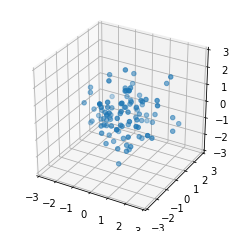

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define input variables
num_dim_emb = 3
num_obj = 100
input_data = {
    'mass': np.ones((num_obj, 1)), 
    'pos': np.empty((num_obj, num_dim_emb)), 
    'vec': np.empty((num_obj, num_dim_emb)),
    'acc': np.zeros((num_obj, num_dim_emb)),
    }

# Generate test objects
np.random.seed(0)
def gen_rand_clusters(input_data, type):
    
    num_obj = input_data['mass'].shape[0]
    num_dim_emb = input_data['pos'].shape[1]

    if type == 'normal':
        input_data['pos'] = np.random.randn(num_obj, num_dim_emb)
        input_data['vec'] = np.random.randn(num_obj, num_dim_emb)
        input_data['acc'] = np.zeros((num_obj, num_dim_emb))

    return input_data


input_data = gen_rand_clusters(input_data, 'normal')



# Plot objects
fig = plt.figure(figsize = (4, 4))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(input_data['pos'][:, 0], input_data['pos'][:, 1], input_data['pos'][:, 2], (0.1)*input_data['mass'])

i = np.ceil(np.max(np.abs([input_data['pos'].max(), input_data['pos'].min()])))
ax.set_xlim(-i, i)
ax.set_ylim(-i, i)
ax.set_zlim(-i, i)


